In [64]:
# Install the OpenAI and LangChain libraries
# - `openai`: Provides access to OpenAI's GPT models for tasks like text generation, embeddings, and completions.
# - `langchain`: A framework for building applications using large language models (LLMs).
#                Includes tools for chaining prompts, memory, and integrations like knowledge graphs.
!pip install -q langchain
# Attempt to install the LangChain Community library
# - `langchain-community`: This may refer to a community-supported version or extensions of LangChain.
#   Ensure this package exists and is maintained if errors occur during installation.
!pip install -q langchain-community

In [65]:
!pip install  rdflib SPARQLWrapper  matplotlib

In [66]:
#!pip install -U openai --quiet
import os
from openai import OpenAI


# # Set the API key in the environment variable
os.environ["OPENAI_API_KEY"] = "sk-MNL1gYbV6CyXkh2rwPxao_D7n8nSxwW4_0wozr5sUtT3BlbkFJoEpwVXUH_Z3deg71NI-mM8QqSOkOGzQ5WDXmQ8FQEA" # Replace with your actual API key

client = OpenAI()

def get_chat_response(text):
    """
    This function takes a text input and returns the chat completion message.
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": text,
            }
        ],
        model="gpt-3.5-turbo",
    )
    return chat_completion.choices[0].message.content


This script initializes the OpenAI API client and defines a function to interact with the GPT model.
The `get_chat_response` function sends a user-provided text input to the GPT model (gpt-3.5-turbo)
and returns the model's response.


In [67]:
import networkx as nx  # For creating and analyzing graphs/networks.

import matplotlib.pyplot as plt  # For data visualization and plotting.

import numpy as np  # For numerical operations and array handling.

import random  # For generating random numbers.

from langchain.graphs.networkx_graph import NetworkxEntityGraph, KnowledgeTriple # Represents (subject, predicate, object) triples.

from scipy.spatial.distance import cosine  # For cosine similarity/distance between vectors.

from scipy.stats import wasserstein_distance  # For Wasserstein distance (probability distribution comparison).

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.linear_model import LinearRegression, BayesianRidge  # Regression models.

from sklearn.datasets import fetch_20newsgroups  # Fetch the 20 Newsgroups text dataset.

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Model performance metrics.

import matplotlib.colors as mcolors  # For handling and customizing colors in visualizations.

import sklearn.metrics  # For evaluation metrics like accuracy, precision, recall, etc.

import matplotlib.colors as mcolors  # For handling color schemes in plots

import textwrap  # For wrapping text into fixed-width lines

from langchain.llms import OpenAI


In [68]:
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your uploaded files
primekg_folder = "/content/drive/MyDrive/PrimeKG_Data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you're using OpenAI with a GraphIndexCreator, and it’s unavailable in the new LangChain version, you can adapt the code using NetworkxEntityGraph for creating and querying a graph with an LLM, or we replaced it with a custom CustomGraphIndexCreator that integrates NetworkxEntityGraph.

In [69]:
from langchain.chains import GraphQAChain  # For question answering over knowledge graphs.

# Prompt Engineering
from langchain.prompts import PromptTemplate  # To define templates for LLM prompts.



This script defines a knowledge graph using a set of triples representing entities (nodes)
and their relationships (edges). The triples are categorized into parts based on themes,
such as LLMs in the legal context, RAG integration, collaborations, and key people involved.
The knowledge graph is constructed programmatically by adding these triples into the graph
index, which allows for efficient querying and analysis.



In [70]:
import openai
print(openai.__version__)

1.97.0


In [71]:
# Mount Google Drive (avoid remounting if already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Set the API key and initialize OpenAI client
os.environ["OPENAI_API_KEY"] = "sk-MNL1gYbV6CyXkh2rwPxao_D7n8nSxwW4_0wozr5sUtT3BlbkFJoEpwVXUH_Z3deg71NI-mM8QqSOkOGzQ5WDXmQ8FQEA"
client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# Paths
file_path = "/content/drive/MyDrive/PrimeKG_Data/final_test.json"
output_dir = "/content/drive/MyDrive/PrimeKG_Data/"

# Embedding cache and model
embedding_cache = {}
EMBEDDING_MODEL = "text-embedding-3-small"

def get_chat_response(text):
    """Send text to GPT model and return response."""
    chat_completion = client.chat.completions.create(
        messages=[{"role": "user", "content": text}],
        model="gpt-3.5-turbo",
    )
    return chat_completion.choices[0].message.content

def normalize_text(text):
    """Normalize text for embedding."""
    text = text.replace("\n", " ").strip()
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    return text

def get_embedding(text):
    """Compute embedding for text using OpenAI API."""
    text = normalize_text(text)
    if text in embedding_cache:
        return embedding_cache[text]
    try:
        response = client.embeddings.create(input=[text], model=EMBEDDING_MODEL)
        embedding = response.data[0].embedding
        embedding_cache[text] = embedding
        return embedding
    except Exception as e:
        print(f"Error getting embedding for '{text}': {e}")
        return [0] * 1536  # Fallback

def load_primekg_data(file_path):
    """Load PrimeKG data from JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} entries from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return []

def is_diabetes_related(text):
    """Determine if text is related to diabetes."""
    core_diabetes_terms = ['diabetes', 'diabetic', 'insulin', 'glucose', 'type 1 diabetes', 'type 2 diabetes', 't1d', 't2d']
    secondary_terms = ['hyperglycemia', 'hypoglycemia', 'glycemic', 'a1c', 'hemoglobin a1c', 'gestational diabetes', 'prediabetes', 'metabolic syndrome', 'pancreatic', 'islet', 'beta cell', 'metformin', 'glucagon', 'diabetic retinopathy', 'diabetic nephropathy', 'diabetic neuropathy']
    text_lower = text.lower()
    for term in core_diabetes_terms:
        if term in text_lower:
            return 2
    for term in secondary_terms:
        if term in text_lower:
            return 1
    return 0

def extract_diabetes_knowledge_graph(data, max_parts=10):
    """Extract diabetes-related knowledge graph from PrimeKG data."""
    all_diabetes_triples = []
    for entry in data:
        triples = entry.get('value', [])
        if not triples:
            continue
        for triple in triples:
            if len(triple) == 3:
                subject, predicate, obj = triple
                subject_decoded = urllib.parse.unquote(subject)
                predicate_decoded = urllib.parse.unquote(predicate)
                obj_decoded = urllib.parse.unquote(obj)
                total_score = is_diabetes_related(subject_decoded) + is_diabetes_related(predicate_decoded) + is_diabetes_related(obj_decoded)
                if total_score > 0:
                    all_diabetes_triples.append((triple, total_score))

    all_diabetes_triples.sort(key=lambda x: x[1], reverse=True)
    G = nx.Graph()
    for (triple, _) in all_diabetes_triples:
        subject, predicate, obj = triple
        subject_decoded = urllib.parse.unquote(subject)
        obj_decoded = urllib.parse.unquote(obj)
        G.add_edge(subject_decoded, obj_decoded, relation=predicate)

    connected_components = list(nx.connected_components(G))
    connected_components.sort(key=len, reverse=True)
    components_to_use = connected_components[:max_parts]

    nodes_to_keep = set()
    for component in components_to_use:
        nodes_to_keep.update(component)

    filtered_triples = []
    for (triple, score) in all_diabetes_triples:
        subject, predicate, obj = triple
        subject_decoded = urllib.parse.unquote(subject)
        obj_decoded = urllib.parse.unquote(obj)
        if subject_decoded in nodes_to_keep and obj_decoded in nodes_to_keep:
            filtered_triples.append(triple)

    kg = []
    portion_indices = {}
    triple_index = 0
    portion_counter = 1

    print("\nStructured Diabetes Knowledge Graph (Focused on Strong Connections):\n")
    component_to_triples = defaultdict(list)
    for triple in filtered_triples:
        subject, _, obj = triple
        subject_decoded = urllib.parse.unquote(subject)
        obj_decoded = urllib.parse.unquote(obj)
        for i, component in enumerate(components_to_use):
            if subject_decoded in component and obj_decoded in component:
                component_to_triples[i].append(triple)
                break

    for component_idx, triples in component_to_triples.items():
        if not triples or portion_counter > max_parts:
            continue
        triples = triples[:20]  # Limit to 20 triples per part
        start_index = triple_index
        end_index = start_index + len(triples)
        portion_indices[f"Part {portion_counter}"] = range(start_index, end_index)
        print(f"\n# Part {portion_counter}")
        for triple in triples:
            subject, predicate, obj = triple
            subject_decoded = urllib.parse.unquote(subject)
            predicate_decoded = urllib.parse.unquote(predicate)
            obj_decoded = urllib.parse.unquote(obj)
            print(f"({subject_decoded}) → ({predicate_decoded}) → ({obj_decoded})")
            kg.append((subject_decoded, predicate_decoded, obj_decoded))
            triple_index += 1
        print("-" * 80)
        portion_counter += 1
        if portion_counter > max_parts:
            break

    return kg, portion_indices

def save_knowledge_graph(kg, output_file=os.path.join(output_dir, "focused_diabetes_kg_accuracy.txt")):
    """Save knowledge graph to a file."""
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            for triple in kg:
                f.write(f"( {triple[0]} , {triple[1]} , {triple[2]} )\n\n")
        print(f"\nFocused Diabetes Knowledge Graph saved as '{output_file}'.")
    except Exception as e:
        print(f"Error saving knowledge graph: {e}")

def wrap_text(text, max_words=8):
    """Wrap text if it exceeds max_words."""
    words = text.split()
    return "\n".join(textwrap.wrap(text, width=15)) if len(words) > max_words else text

def visualize_graph_with_chains(kg, part_indices):
    """Visualize knowledge graph with chain membership."""
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        G.add_edge(node1, node2, label=relation)
    pos = nx.spring_layout(G, k=8, iterations=100, seed=0)
    chain_cmap = mcolors.LinearSegmentedColormap.from_list('chain_colors', ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'])
    chain_norm = mcolors.Normalize(vmin=0, vmax=len(part_indices) - 1)
    node_colors = ['lightblue'] * len(G.nodes())
    edge_colors = ['gray'] * len(G.edges())
    chain_color_map = {f"Part {i+1}": chain_cmap(chain_norm(i)) for i in range(len(part_indices))}
    node_chain_map = {}
    for chain_name, indices in part_indices.items():
        color = chain_color_map[chain_name]
        for idx in indices:
            node1, _, node2 = kg[idx]
            if node1 in G.nodes:
                node_chain_map[node1] = chain_name
                node_colors[list(G.nodes).index(node1)] = color
            if node2 in G.nodes:
                node_chain_map[node2] = chain_name
                node_colors[list(G.nodes).index(node2)] = color
        for i, (node1, node2) in enumerate(G.edges()):
            for idx in indices:
                n1, _, n2 = kg[idx]
                if (node1, node2) == (n1, n2):
                    edge_colors[i] = color
                    break
    wrapped_labels = {node: wrap_text(node) for node in G.nodes()}
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), dpi=600)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200, ax=axs[0])
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.2, ax=axs[0])
    nx.draw_networkx_labels(G, pos, labels=wrapped_labels, font_size=6, ax=axs[0])
    edge_labels = nx.get_edge_attributes(G, 'label')
    wrapped_edge_labels = {edge: wrap_text(label) for edge, label in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=wrapped_edge_labels, font_size=6, ax=axs[0])
    axs[0].set_title("Original Diabetes Knowledge Graph", fontsize=10)
    axs[0].axis('off')
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200, ax=axs[1], edgecolors='black')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=axs[1])
    nx.draw_networkx_labels(G, pos, labels=wrapped_labels, font_size=6, ax=axs[1])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=wrapped_edge_labels, font_size=6, ax=axs[1])
    axs[1].set_title("Diabetes Graph Highlighted by Chain Membership", fontsize=10)
    axs[1].axis('off')
    handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', label=chain_name)
               for chain_name, color in chain_color_map.items()]
    axs[1].legend(handles=handles, title="Chains", loc='upper right', fontsize=8)
    plt.show()
    print("\n--- Node Chain Mapping ---")
    for node, chain in node_chain_map.items():
        print(f"Node '{node}' belongs to chain '{chain}'.")

def perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices):
    """Perturb knowledge graph by removing specified parts."""
    indices_to_remove = set()
    for part in parts_to_remove:
        if part in portion_indices:
            indices_to_remove.update(portion_indices[part])
    perturbed_kg = [triple for i, triple in enumerate(kg) if i not in indices_to_remove]
    return perturbed_kg

def get_answer_and_embedding(question: str, temp: float, graph):
    """Query GraphQAChain and return answer and embedding."""
    llm = LangChainOpenAI(temperature=temp, api_key=os.environ["OPENAI_API_KEY"])
    chain = GraphQAChain.from_llm(llm, graph=graph, verbose=False)
    response = chain.invoke({"query": question})
    original_answer = response.get("result", "")
    original_answer_str = str(original_answer)
    original_answer_embedding = get_embedding(original_answer_str)
    return original_answer_str, original_answer_embedding

def wrap_label(label, width=15):
    """Wrap labels for visualization."""
    return '\n'.join(textwrap.wrap(label, width))

def build_graph(kg, coeff, part_indices):
    """Build graph with colors and sizes for explainability."""
    G = nx.DiGraph()
    for node1, relation, node2 in kg:
        wrapped_node1 = wrap_label(node1)
        wrapped_node2 = wrap_label(node2)
        wrapped_relation = wrap_label(relation)
        G.add_edge(wrapped_node1, wrapped_node2, label=wrapped_relation)
    pos = nx.spring_layout(G, k=8, iterations=200, seed=0)
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    node_sizes = [1500 + 100 * G.degree(node) for node in G.nodes()]
    node_colors = []
    edge_colors = []
    for node in G.nodes():
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            coeff_value = coeff[part_idx]
            color = cmap(norm(coeff_value))
            if any(i < len(kg) and (wrap_label(node) == wrap_label(kg[i][0]) or wrap_label(node) == wrap_label(kg[i][2])) for i in indices):
                node_colors.append(color)
                break
        else:
            node_colors.append('#8da0cb')
    for i, (node1, node2) in enumerate(G.edges()):
        for part_name, indices in part_indices.items():
            part_idx = int(part_name.split()[-1]) - 1
            coeff_value = coeff[part_idx]
            color = cmap(norm(coeff_value))
            if any(i < len(kg) and (node1 == wrap_label(kg[i][0]) and node2 == wrap_label(kg[i][2])) for i in indices):
                edge_colors.append(color)
                break
        else:
            edge_colors.append('gray')
    return G, pos, node_sizes, node_colors, edge_colors

def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """Visualize knowledge graph with explainability features."""
    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)
    ax.set_title("Diabetes Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)
    plt.savefig(os.path.join(output_dir, 'diabetes_knowledge_graph_explainability.png'), bbox_inches='tight')
    plt.show()

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """Calculate and print fidelity metrics."""
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """Plot actual vs. predicted values."""
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    normalized_weights = np.array(weights) / np.max(weights) * 100 if weights is not None else 50
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()
    plt.show()

# Main execution
data = load_primekg_data(file_path)
kg, portion_indices = extract_diabetes_knowledge_graph(data)
save_knowledge_graph(kg)

# Build NetworkX graph
graph = NetworkxEntityGraph()
for node1, relation, node2 in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))

# Define diabetes-related question
question = "What is insulin-like growth factor receptor binding associated with?"
temp = 0
original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph)
print(f"\nAnswer to '{question}':\n{original_answer_str}")

# Perturb knowledge graph (example: remove Part 1)
parts_to_remove = ["Part 1"]
perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)

# Rebuild perturbed graph
perturbed_graph = NetworkxEntityGraph()
for node1, relation, node2 in perturbed_kg:
    perturbed_graph.add_triple(KnowledgeTriple(node1, relation, node2))

# Query perturbed graph
perturbed_answer_str, perturbed_answer_embedding = get_answer_and_embedding(question, temp, perturbed_graph)
print(f"\nAnswer from perturbed graph:\n{perturbed_answer_str}")

Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated with) → (Ne

# Exploring Explainability: Fidelity Metrics Comparison for Text vs. Text and Graph vs. Graph Representations Using Cosine, wasserstein_distance, and Combined Approaches


Visualizes the knowledge graph as a directed graph using NetworkX and Matplotlib.
Nodes represent entities, and edges depict relationships with labels for clarity.
The layout uses spring positioning with increased spacing for readability. Custom
node colors and labeled edges enhance the visualization, displayed without axes.



Defines a function to perturb the knowledge graph by selectively removing triples
belonging to specified parts. This allows testing the impact of missing information
on downstream tasks or analysis. The function filters out triples associated with
the indices of the parts to be removed and returns the modified knowledge graph.


Defines a function to query a GraphQAChain with a question and temperature setting,
returning the answer and its embedding. The function initializes the chain with a
specified graph and temperature, processes the question, and computes the embedding
for the returned answer, facilitating downstream analysis or comparison.


This function computes the embedding for a given text using a specified model.
It processes the text by removing newline characters and queries the OpenAI
embeddings API to generate a vector representation, useful for similarity
comparisons and downstream tasks.

This function visualizes the explainability of a knowledge graph by displaying the original graph and an
enhanced graph with nodes and edges colored based on their importance coefficients. It leverages a directed
graph structure, wraps node labels for readability, adjusts node sizes based on connectivity, and applies a
custom colormap to represent the significance of graph components. The visualization is presented in a
two-panel layout, highlighting both the original structure and the explainability features derived from
Simple SMILE GraphRAG analysis. A color bar provides a reference for importance coefficients.


This function computes and displays fidelity metrics for evaluating regression model performance,
including standard measures like Mean Squared Error (MSE), R-squared (R²), and Mean Absolute Error (MAE).
It also calculates advanced metrics such as weighted R², weighted adjusted R², mean losses (L1 and L2),
and weighted losses. These metrics provide a comprehensive assessment of model fidelity, considering
weights and coefficients for a nuanced evaluation of the regression results.

This function generates a scatter plot comparing actual (true) values to predicted values,
with an optional weighting mechanism to scale point sizes. It includes a perfect prediction
line (y = x) for reference and displays the R² score as a measure of model performance. The
plot provides an intuitive visual assessment of the alignment between predictions and ground
truth, with customizable point size based on weights for better visualization.

Defines the question to query the GraphQAChain or knowledge retrieval system.
Here, the question "What is RAG?" seeks information about Retrieval-Augmented Generation,
a framework that integrates external knowledge bases to improve the accuracy and reliability
of AI-generated responses.

This snippet sets the temperature parameter to 0 for deterministic response generation and
queries the GraphQAChain with the question, "What is RAG?". The function `get_answer_and_embedding`
returns the original answer as a string along with its embedding. The answer is then printed for review.

This script evaluates the robustness of a knowledge graph system by perturbing the graph and measuring the
impact on the generated responses. It iteratively removes random parts of the graph, calculates similarity
metrics (Wasserstein distance and cosine similarity) between the original and perturbed response embeddings,
and stores the perturbation details for analysis. Additionally, it computes cosine distances and kernel-based
weights for further analysis of the perturbations' impact.

Key Steps:
1. Generate perturbed versions of the knowledge graph by randomly removing parts.
2. Create embeddings for responses from the perturbed graphs.
3. Calculate similarity metrics between original and perturbed responses.
4. Compute kernel-based weights using cosine distances for downstream tasks.

# BayLIME: Dual Metrics: Blending Inverse Wasserstein Distance and Cosine Similarity for Text and Graph-to-Graph using Cosine
Cosine Similarity: Measuring Alignment and Fidelity Between Textual Representations
Wasserstein Distance: Evaluating Semantic Shifts Between Textual Representations


Successfully loaded 17074 entries from /content/drive/MyDrive/PrimeKG_Data/final_test.json

Structured Diabetes Knowledge Graph (Focused on Strong Connections):


# Part 1
(Neonatal insulin-dependent diabetes mellitus) → (associated with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (associated with) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (ppi) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated with) → (Neonatal insulin-dependent diabetes mellitus)
(Neonatal insulin-dependent diabetes mellitus) → (ppi) → (insulin-like growth factor receptor binding)
(insulin-like growth factor receptor binding) → (associated with) → (Ne

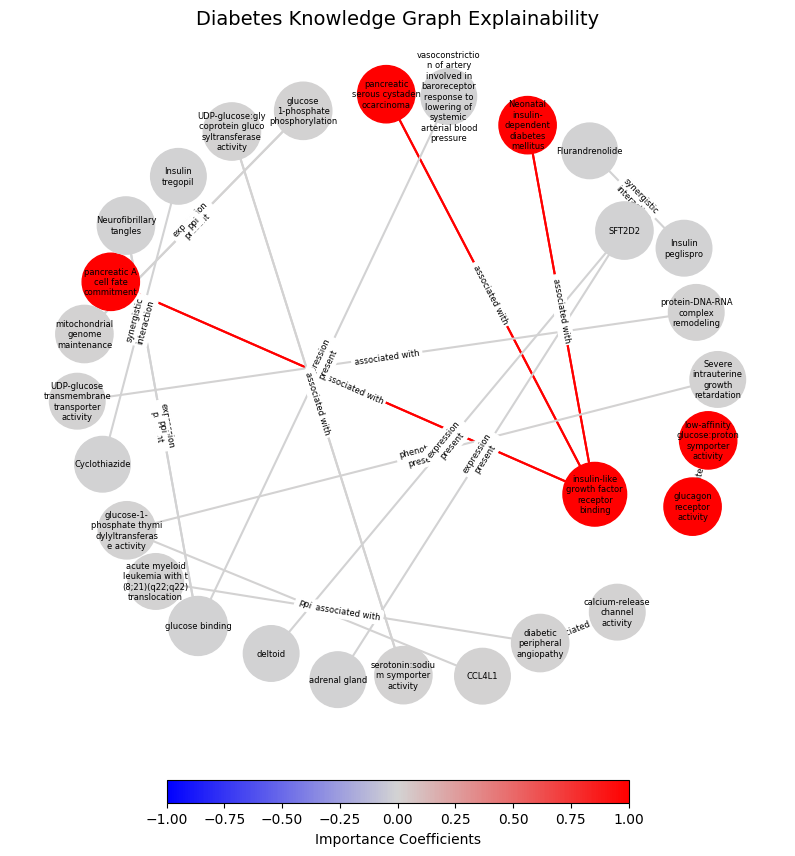

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 2.703535441939481e-12
R-squared (R²): 0.9999999999897807
Mean Absolute Error (MAE): 9.277910262083489e-07
Mean Loss (Lm): 2.29867571421849e-07
Mean L1 Loss: 1.7796331952590893e-06
Mean L2 Loss: 8.700631008743568e-12
Weighted L1 Loss: 3.335002725468965e-07
Weighted L2 Loss: 9.718026810538876e-13
Weighted R-squared (R²ω): 0.9999999999897807
Weighted Adjusted R-squared (Rˆ²ω): 0.999999999978426
----------------------------------------------------------------------------------------------------


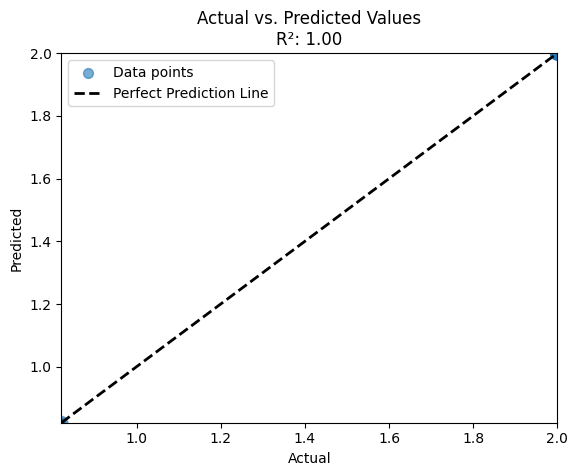

In [73]:
def plot_knowledge_graph_explainability(kg, part_indices, coeff):
    """Visualize knowledge graph with explainability features."""
    G, pos, node_sizes, node_colors, edge_colors = build_graph(kg, coeff, part_indices)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)
    ax.set_title("Diabetes Knowledge Graph Explainability", fontsize=14)
    ax.axis('off')
    cmap = mcolors.LinearSegmentedColormap.from_list('red_blue', ['blue', '#d3d3d3', 'red'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Importance Coefficients', fraction=0.03, pad=0.05)
    plt.savefig(os.path.join(output_dir, 'diabetes_knowledge_graph_explainability.png'), bbox_inches='tight')
    plt.show()

def calculate_fidelity_metrics(y_true, y_pred, weights, coeff):
    """Calculate and print fidelity metrics."""
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
    mean_loss_f = np.mean(y_true)
    mean_loss_g = np.mean(y_pred)
    mean_loss = abs(mean_loss_f - mean_loss_g)
    mean_l1 = np.mean(np.abs(y_true - y_pred))
    mean_l2 = np.mean((y_true - y_pred) ** 2)
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(y_true - y_pred)) / n
    weighted_l2 = np.sum(weights * (y_true - y_pred) ** 2) / n
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot
    p = len(coeff)
    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)
    print(100 * '-')
    print('Fidelity:')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Loss (Lm): {mean_loss}")
    print(f"Mean L1 Loss: {mean_l1}")
    print(f"Mean L2 Loss: {mean_l2}")
    print(f"Weighted L1 Loss: {weighted_l1}")
    print(f"Weighted L2 Loss: {weighted_l2}")
    print(f"Weighted R-squared (R²ω): {weighted_r2}")
    print(f"Weighted Adjusted R-squared (Rˆ²ω): {weighted_adj_r2}")
    print(100 * '-')

def plot_actual_vs_predicted(y_true, y_pred, weights=None):
    """Plot actual vs. predicted values."""
    r2 = r2_score(y_true, y_pred, sample_weight=weights)
    normalized_weights = np.array(weights) / np.max(weights) * 100 if weights is not None else 50
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=normalized_weights, label='Data points', alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs. Predicted Values\nR²: {r2:.2f}')
    ax.legend()
    plt.show()

# Main execution
data = load_primekg_data(file_path)
kg, portion_indices = extract_diabetes_knowledge_graph(data)
save_knowledge_graph(kg)

# Define part names
part_names = list(portion_indices.keys())

# Define the original vector
original = np.ones(len(part_names)).reshape(1, -1)

# Build NetworkX graph
graph = NetworkxEntityGraph()
for node1, relation, node2 in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))

# Define diabetes-related question
question = "What is insulin-like growth factor receptor binding associated with??"  # Changed to leverage KG triples
temp = 0
original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph)
print(f"\nAnswer to '{question}':\n{original_answer_str}")

# Perturbation analysis
similarities_wd = []
similarities_cosine = []
perturbations_vect2 = []
perturbation_texts = []

# Loop for perturbations
for i in range(20):
    perturbation_vector = original.copy().flatten()
    num_parts_to_remove = random.randint(1, len(part_names))
    parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)
    for part_idx in parts_to_remove_indices:
        perturbation_vector[part_idx] = 0
    perturbations_vect2.append(perturbation_vector)
    parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]
    perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)
    graph_temp = NetworkxEntityGraph()
    for node1, relation, node2 in perturbed_kg:
        graph_temp.add_triple(KnowledgeTriple(node1, relation, node2))
    temp_response, temp_response_embedding = get_answer_and_embedding(question, temp, graph_temp)
    perturbation_texts.append(temp_response)
    similarity_wd = wasserstein_distance(original_answer_embedding, temp_response_embedding)
    similarities_wd.append(similarity_wd)
    similarity_cosine = 1 - cosine(original_answer_embedding, temp_response_embedding)
    similarities_cosine.append(similarity_cosine)
    print(f"Iteration {i + 1}")
    print(f"Parts removed: {parts_to_remove}")
    print(f"Original answer: {original_answer_str}")
    print(f"Perturbed response: {temp_response}")
    print(f"Wasserstein Distance with original answer: {similarity_wd}")
    print(f"Cosine Similarity with original answer: {similarity_cosine}\n")

# Convert perturbations to numpy array
perturbations_vect2 = np.array(perturbations_vect2)

# Calculate cosine distances and weights
distances = sklearn.metrics.pairwise_distances(perturbations_vect2, original, metric='cosine').ravel()
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))

# Print similarities and weights
print(f"Wasserstein Distances: {similarities_wd}")
print(f"Cosine Similarities: {similarities_cosine}")
print(f"Weights: {weights}")

# Print perturbation texts
print("\n--- Summary of Perturbations ---")
for i, text in enumerate(perturbation_texts):
    print(f"Perturbation {i + 1}: {text}")

# Combined similarity metric (BayLIME)
epsilon = 1e-6
inverse_similarities_wd = [1.0 / (dist + epsilon) for dist in similarities_wd]
min_value = min(inverse_similarities_wd)
max_value = max(inverse_similarities_wd)
if max_value == min_value:
    scaled_similarities_wd = [1.0 for _ in inverse_similarities_wd]  # Fallback to avoid division by zero
else:
    scaled_similarities_wd = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]
Similarities_ = [wd + cos for wd, cos in zip(scaled_similarities_wd, similarities_cosine)]
print(f"\nCombined Similarities: {Similarities_}")

# Train Bayesian Ridge regression
simpler_model = BayesianRidge()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
print(f"\nRegression Coefficients: {coeff}")

# Visualize explainability
plot_knowledge_graph_explainability(kg, portion_indices, coeff)

# Calculate and plot fidelity metrics
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)
plot_actual_vs_predicted(y_true, y_pred, weights)

This script computes a combined similarity metric by scaling inverse Wasserstein distances
(to normalize between 0 and 1) and adding them to cosine similarities. The result, stored
in `Similarities_`, provides a composite measure of fidelity, highlighting the alignment
between perturbed and original responses in the knowledge graph system.

This code trains a Bayesian Ridge regression model to learn the relationship between perturbation vectors
(`perturbations_vect2`) and the combined similarity metric (`Similarities_`). The model incorporates sample
weights (`weights`) to prioritize certain data points. After training, the coefficients (`coeff`) of the model
are extracted, which represent the importance of each feature in predicting the similarity metric.

This code defines the importance coefficients (`coeff`) for different parts of the knowledge graph
and visualizes their explainability using the `plot_knowledge_graph_explainability` function. The
coefficients indicate the contribution of each part to the overall fidelity, and the visualization
highlights these contributions through node and edge color mappings in the graph.

This code calculates fidelity metrics to evaluate the performance of the Bayesian Ridge regression model.
The true similarity values (`y_true`) and predicted values (`y_pred`) are passed to the
`calculate_fidelity_metrics` function, along with sample weights (`weights`) and model coefficients (`coeff`).
The function outputs metrics like MSE, R², weighted R², and other advanced measures for a comprehensive
assessment of the model's fidelity.

This code generates a scatter plot to visually compare the true similarity values (`y_true`) against the
predicted values (`y_pred`). The function `plot_actual_vs_predicted` scales point sizes based on sample
weights (`weights`) and includes a reference line for perfect predictions (y = x). It also displays the
R² score to quantify the model's predictive accuracy.

# BayLIME: Analyzing Fidelity: Comparing Text and Graph Representations Using Cosine Similarity.

In [74]:
simpler_model =  BayesianRidge()
simpler_model.fit(X=perturbations_vect2, y=similarities_cosine, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.78384331e-01, -2.27548018e-05, -2.16585320e-05,  1.29293313e-05,
        3.15807960e-05, -4.90050710e-06,  1.13651058e-06,  5.95466832e-05,
       -1.76487413e-05,  7.20654268e-06])

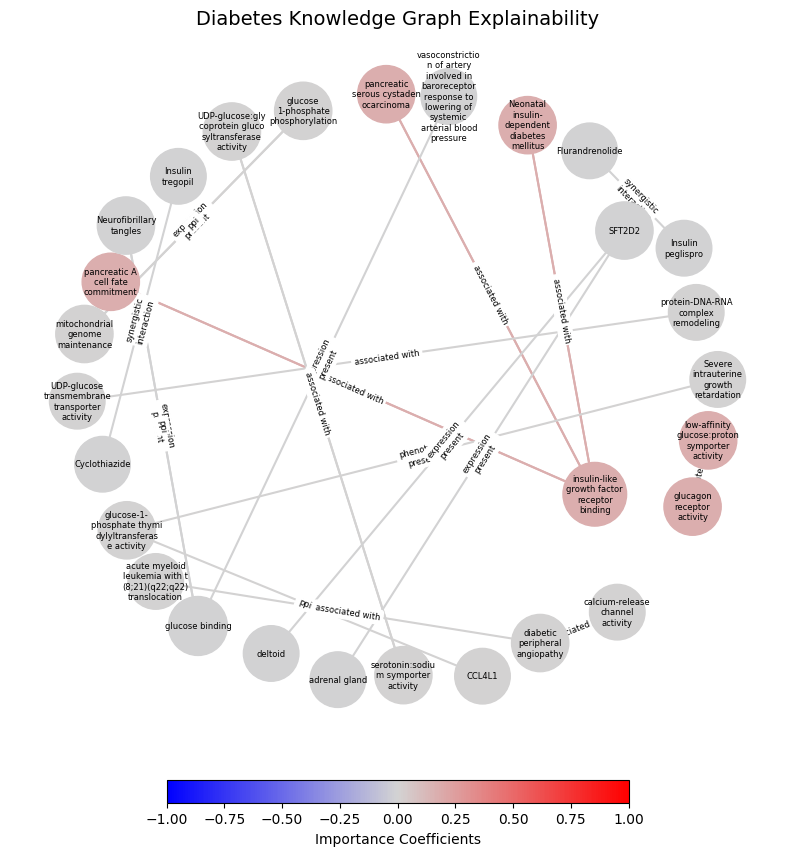

In [75]:
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)

In [76]:
y_true = np.array(similarities_cosine).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 1.1782806568268372e-10
R-squared (R²): 0.999999980578354
Mean Absolute Error (MAE): 6.1242955223439644e-06
Mean Loss (Lm): 1.5190935028774888e-06
Mean L1 Loss: 1.1746034428489205e-05
Mean L2 Loss: 3.791721742371426e-10
Weighted L1 Loss: 2.2014162329274217e-06
Weighted L2 Loss: 4.235403329933073e-11
Weighted R-squared (R²ω): 0.999999980578354
Weighted Adjusted R-squared (Rˆ²ω): 0.9999999589987474
----------------------------------------------------------------------------------------------------


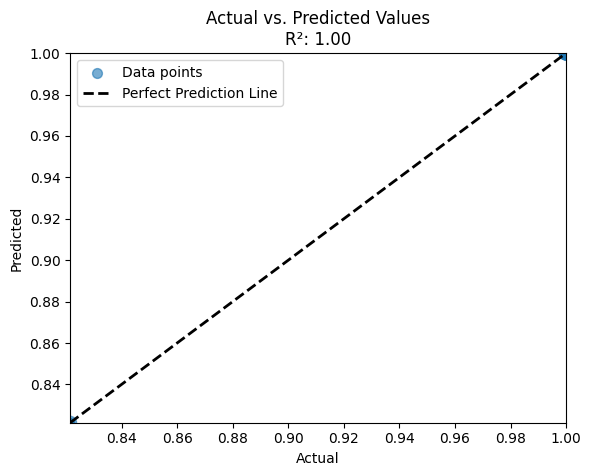

In [77]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# BayLIME: Fidelity Analysis of Text-to-Text using Inverse Wasserstein Distance and Graph-to-Graph using Cosine


In [78]:
Similarities_ = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]
print(Similarities_)

[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0)]


In [79]:
simpler_model = BayesianRidge()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 9.99986504e-01, -4.06302590e-06, -3.86679597e-06,  2.30565185e-06,
        5.63867378e-06, -8.74957483e-07,  2.02074985e-07,  1.06321978e-05,
       -3.15199481e-06,  1.28667490e-06])

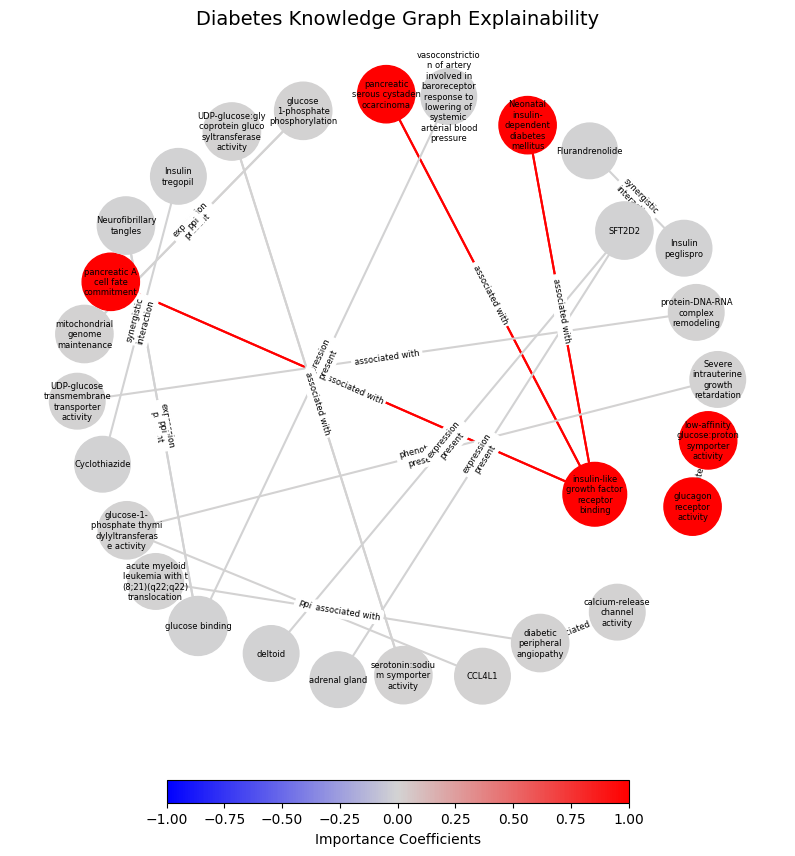

In [80]:
# Define importance coefficients
#coeff = np.array([ 3.28418237e-05, -3.60859654e-05,  9.99996056e-01, -4.41499600e-05, 1.93175917e-05,  4.99926463e-05,  3.78055664e-05, -2.83822627e-05, -6.86463434e-06,  1.55103960e-05])
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [81]:
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 3.754564642990665e-12
R-squared (R²): 0.9999999999802903
Mean Absolute Error (MAE): 1.0933606747188468e-06
Mean Loss (Lm): 2.708916144733564e-07
Mean L1 Loss: 2.0972169898223272e-06
Mean L2 Loss: 1.2083089349685835e-11
Weighted L1 Loss: 3.9301531563737044e-07
Weighted L2 Loss: 1.3496016843895838e-12
Weighted R-squared (R²ω): 0.9999999999802903
Weighted Adjusted R-squared (Rˆ²ω): 0.9999999999583907
----------------------------------------------------------------------------------------------------


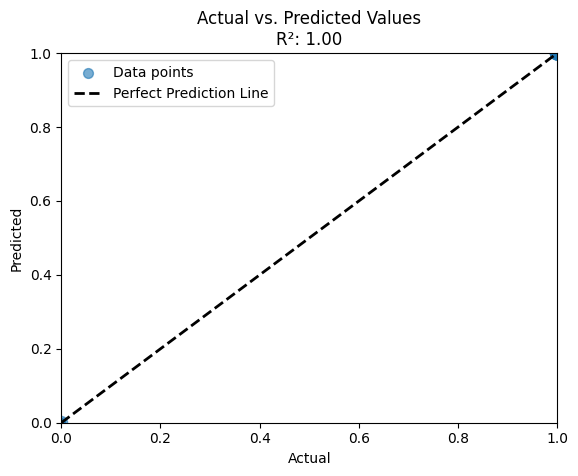

In [82]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# Linear : Analyzing Fidelity: Comparing Text and Graph Representations Using Cosine Similarity.

In [83]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations_vect2, y=similarities_cosine, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.78459937e-01,  1.38786064e-16,  8.34369003e-17,  1.03072086e-16,
       -1.18151028e-16, -1.36266346e-16, -8.56506177e-18,  2.03945673e-17,
       -3.60665244e-17,  1.26081408e-16])

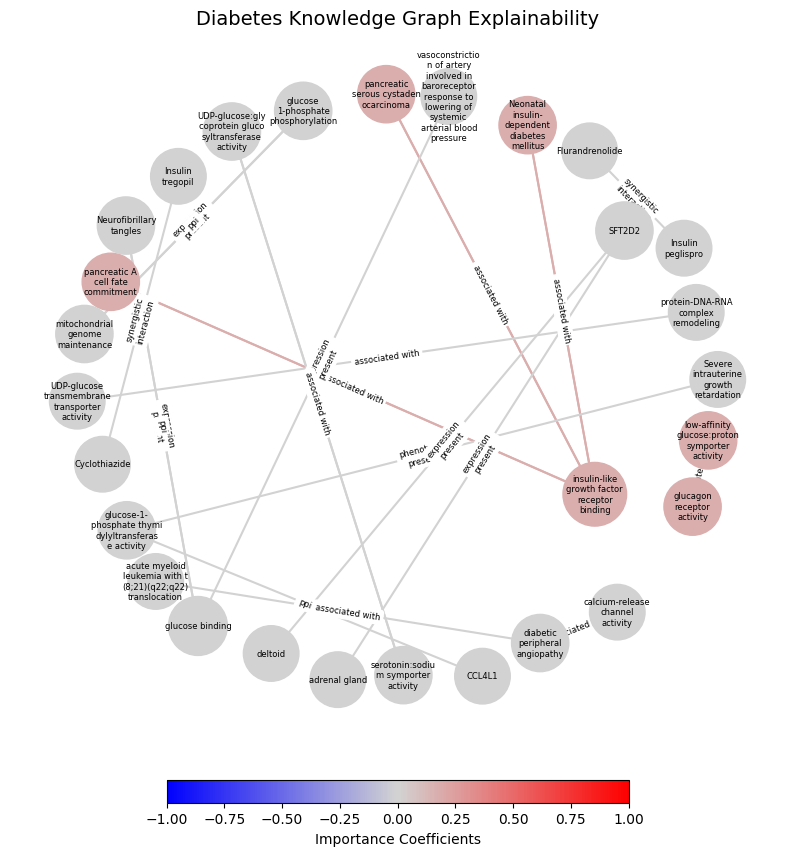

In [84]:
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [85]:
y_true = np.array(similarities_cosine).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 1.851010211351248e-32
R-squared (R²): 1.0
Mean Absolute Error (MAE): 8.328189975778527e-17
Mean Loss (Lm): 2.220446049250313e-16
Mean L1 Loss: 2.0539125955565397e-16
Mean L2 Loss: 6.101346063818763e-32
Weighted L1 Loss: 2.99361984357106e-17
Weighted L2 Loss: 6.653571683006376e-33
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------


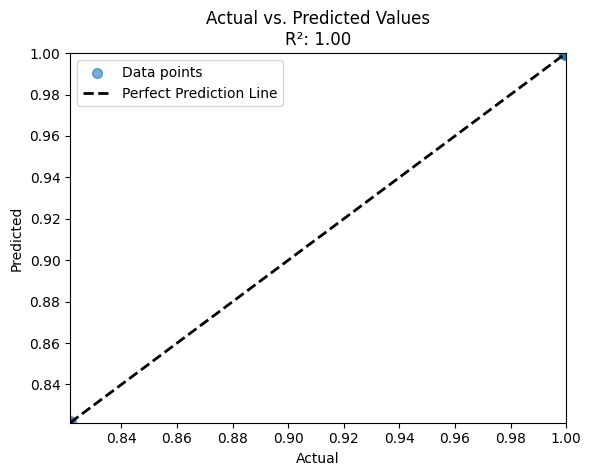

In [86]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# Linear: Fidelity Analysis of Text-to-Text using Inverse Wasserstein Distance and Graph-to-Graph using Cosine

In [87]:
# Scale between 0 and 1
Similarities_ = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]
print(Similarities_)

[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0)]


In [88]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.00000000e+00,  7.92898344e-16,  5.16775077e-16,  2.96744461e-16,
       -5.03466956e-16, -7.08815416e-16, -2.12347526e-16,  1.63035049e-16,
       -2.26579049e-16,  7.29151475e-16])

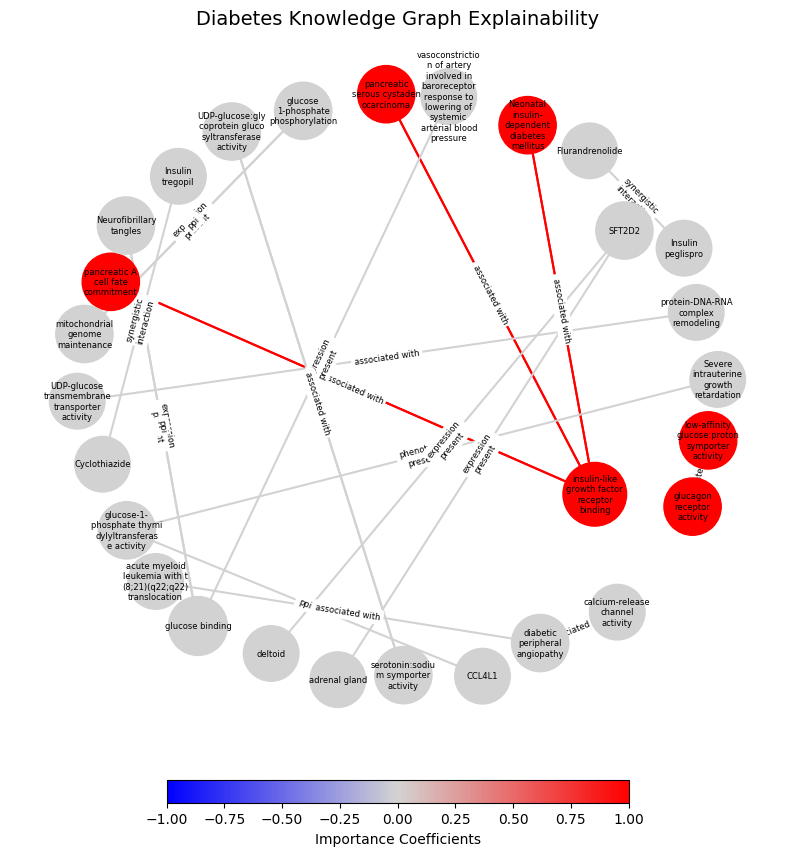

In [89]:
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [90]:
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 4.378946267912002e-31
R-squared (R²): 1.0
Mean Absolute Error (MAE): 5.23126186890372e-16
Mean Loss (Lm): 7.771561172376096e-16
Mean L1 Loss: 9.490661976191215e-16
Mean L2 Loss: 1.1797222654762303e-30
Weighted L1 Loss: 1.8804097148615842e-16
Weighted L2 Loss: 1.57403955477461e-31
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------


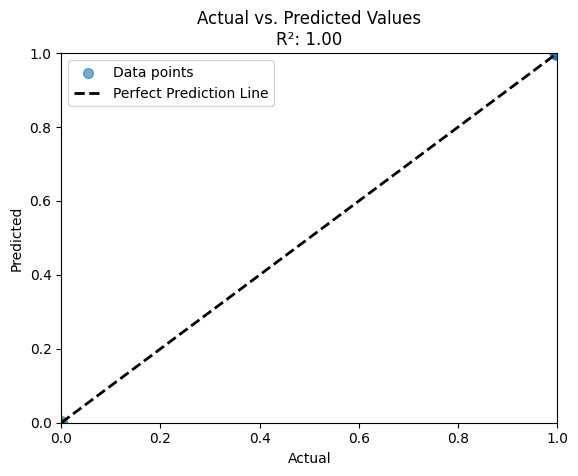

In [91]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# Linear : Dual Metrics: Blending Inverse Wasserstein Distance and Cosine Similarity for Text and Graph-to-Graph using Cosine
Cosine Similarity: Measuring Alignment and Fidelity Between Textual Representations
Wasserstein Distance: Evaluating Semantic Shifts Between Textual Representations


In [92]:
# Combine the scaled inverse Wasserstein distances and cosine similarities
Similarities_ = [wd + cos for wd, cos in zip(scaled_similarities_wd, similarities_cosine)]
# Print the combined list of similarities
print(Similarities_)

[np.float64(0.8215400634851585), np.float64(2.0), np.float64(0.8215400634851585), np.float64(2.0), np.float64(2.0), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(2.0), np.float64(2.0), np.float64(0.8215400634851585), np.float64(0.8215400634851585), np.float64(2.0), np.float64(0.8215400634851585), np.float64(2.0)]


In [93]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.17845994e+00,  8.15089947e-16,  4.55062336e-16,  6.37172209e-16,
       -4.78874121e-16, -9.09270602e-16, -1.43961503e-16,  2.78858400e-16,
       -4.14203150e-16,  1.02439123e-15])

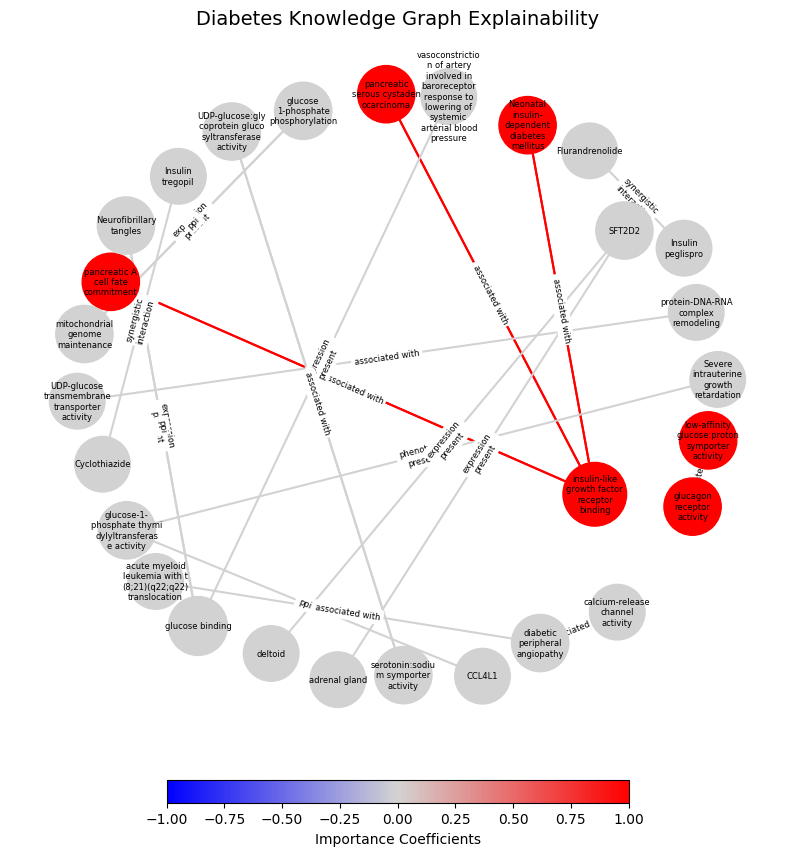

In [94]:
# Define importance coefficients
# coeff = np.array([ 0.02697915, -0.03295622,  1.26706576, -0.03733343,  0.01843998,
#         0.04205821,  0.02872399, -0.02679586, -0.00285397,  0.0098997 ])
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [95]:
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 5.962630624571422e-31
R-squared (R²): 1.0
Mean Absolute Error (MAE): 6.292319859226381e-16
Mean Loss (Lm): 6.661338147750939e-16
Mean L1 Loss: 9.048317650695026e-16
Mean L2 Loss: 1.0840674470966874e-30
Weighted L1 Loss: 2.261813629067157e-16
Weighted L2 Loss: 2.143304776850133e-31
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------


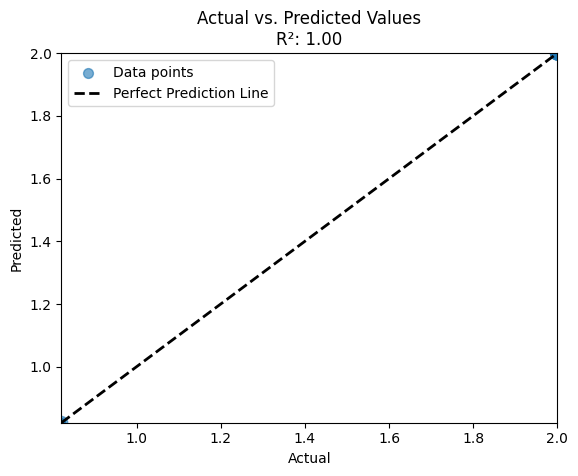

In [96]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# Linear: Fidelity Analysis of Text-to-Text using Wasserstein Distance and Graph-to-Graph using Cosine

In [97]:
min_value_wd= min(similarities_wd)
max_value_wd = max(similarities_wd)
# Scale between 0 and 1
Similarities_ = [(value - min_value_wd) / (max_value_wd - min_value_wd) for value in similarities_wd]
print(Similarities_)

[np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(0.0)]


In [98]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([-1.00000000e+00, -8.63923589e-16, -5.28347000e-16, -4.34514996e-16,
        6.38744500e-16,  7.29551476e-16,  1.71311493e-16,  1.48350125e-17,
        1.63582530e-16, -7.99048242e-16])

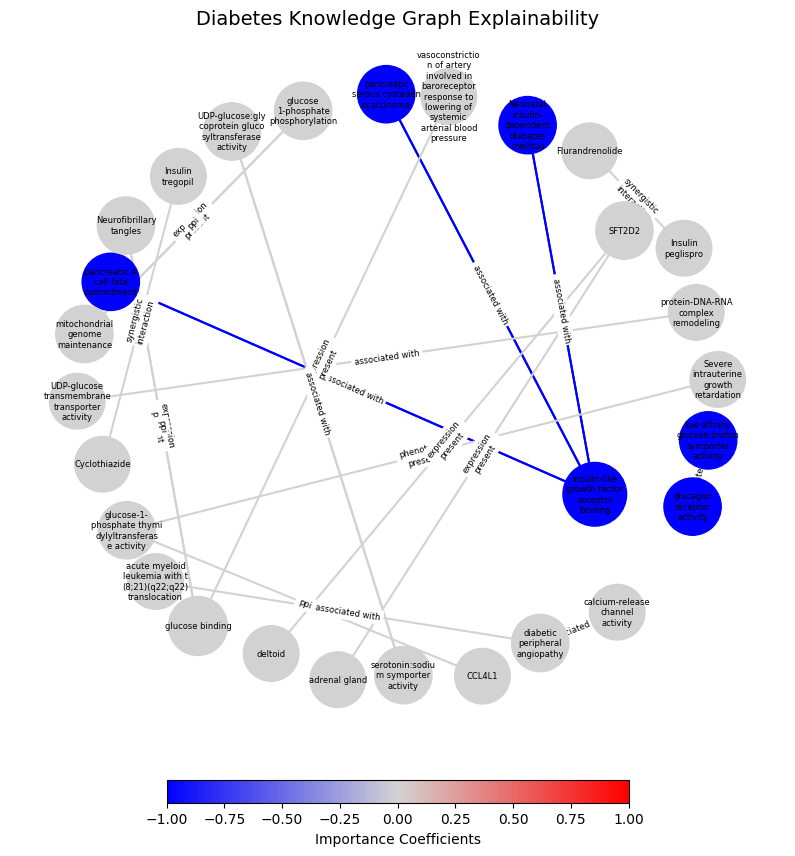

In [99]:
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)

In [100]:
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 4.543362468743093e-31
R-squared (R²): 1.0
Mean Absolute Error (MAE): 4.865398693702274e-16
Mean Loss (Lm): 5.551115123125783e-16
Mean L1 Loss: 7.216449660063518e-16
Mean L2 Loss: 7.568134309464082e-31
Weighted L1 Loss: 1.7488979140380713e-16
Weighted L2 Loss: 1.633139983900749e-31
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------


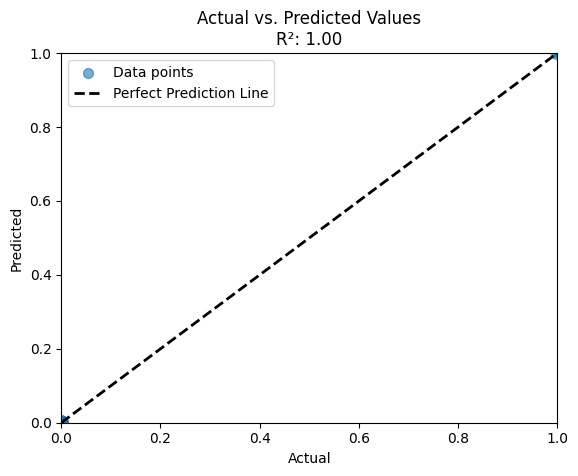

In [101]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# BayLime: Fidelity Analysis of Text-to-Text using Wasserstein Distance and Graph-to-Graph using Cosine

In [102]:
# Scale between 0 and 1
Similarities_ = [(value - min_value_wd) / (max_value_wd - min_value_wd) for value in similarities_wd]

In [103]:
simpler_model = BayesianRidge()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([-9.99986504e-01,  4.06302590e-06,  3.86679597e-06, -2.30565185e-06,
       -5.63867378e-06,  8.74957483e-07, -2.02074985e-07, -1.06321978e-05,
        3.15199481e-06, -1.28667490e-06])

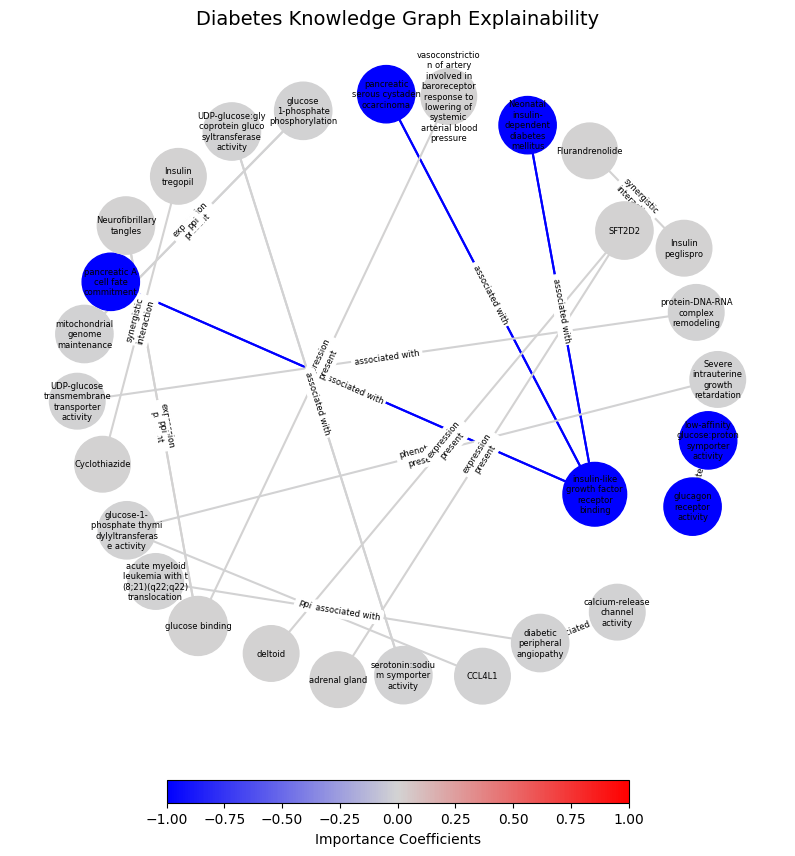

In [104]:
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [105]:
# Example inputs
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 3.754564642413463e-12
R-squared (R²): 0.9999999999802903
Mean Absolute Error (MAE): 1.0933606745607852e-06
Mean Loss (Lm): 2.708916143623341e-07
Mean L1 Loss: 2.0972169895661087e-06
Mean L2 Loss: 1.2083089347512138e-11
Weighted L1 Loss: 3.930153155805542e-07
Weighted L2 Loss: 1.3496016841821048e-12
Weighted R-squared (R²ω): 0.9999999999802903
Weighted Adjusted R-squared (Rˆ²ω): 0.9999999999583907
----------------------------------------------------------------------------------------------------


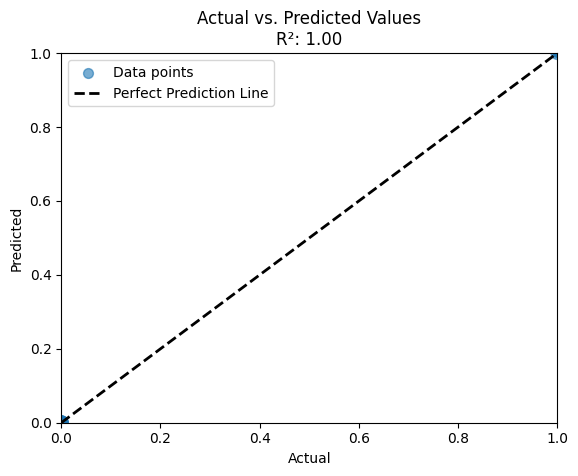

In [106]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# BayLIME: Hybrid Text Metrics (Wasserstein Distance + Cosine) vs. Graph Metrics (Cosine) Fidelity Analysis.

In [107]:
# Combine the scaled inverse Wasserstein distances and cosine similarities
Similarities= [wd + cos for wd, cos in zip(similarities_wd, similarities_cosine)]
# Print the combined list of similarities
print(Similarities)

[np.float64(0.8223208527696352), np.float64(1.0), np.float64(0.8223208527696352), np.float64(1.0), np.float64(1.0), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(1.0), np.float64(1.0), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(1.0), np.float64(0.8223208527696352), np.float64(1.0)]


In [108]:
simpler_model = BayesianRidge()
simpler_model.fit(X=perturbations_vect2, y=Similarities, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.77603210e-01, -2.28546817e-05, -2.17536247e-05,  1.29862352e-05,
        3.17194318e-05, -4.92202054e-06,  1.14154304e-06,  5.98080712e-05,
       -1.77261733e-05,  7.23818039e-06])

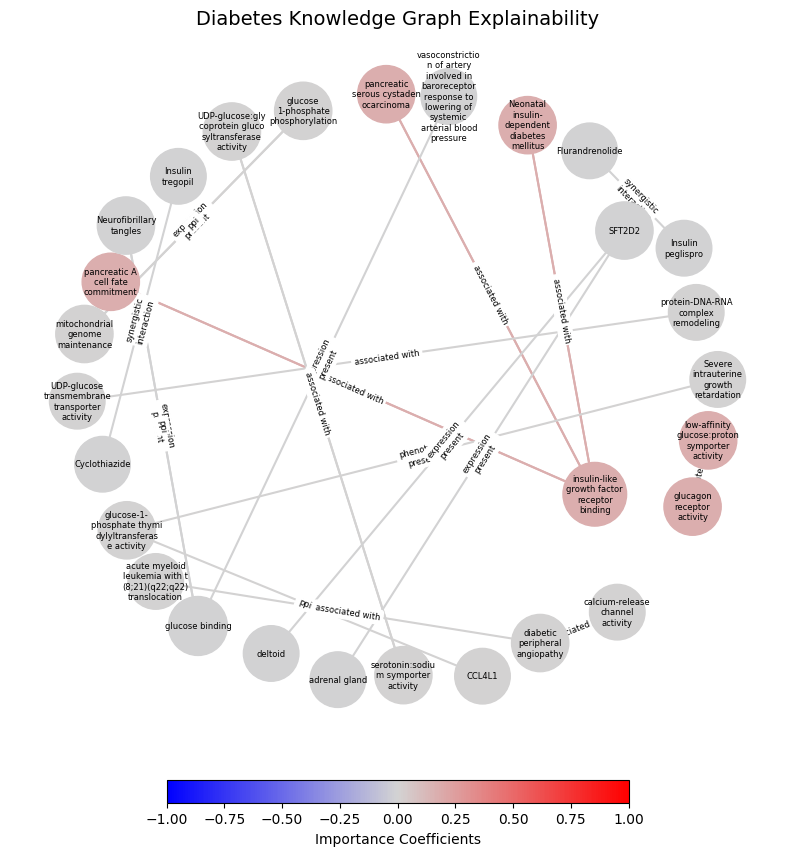

In [109]:
# Define importance coefficients
# coeff = np.array([ 0.02418697, -0.02465132,  0.25294701, -0.03245874,  0.01325452,
#         0.03718056,  0.03042151, -0.01965449, -0.00673555,  0.01327148])
# Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [110]:
y_true = np.array(Similarities).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 1.1886532802018384e-10
R-squared (R²): 0.9999999802348086
Mean Absolute Error (MAE): 6.151186421601689e-06
Mean Loss (Lm): 1.5257794737655317e-06
Mean L1 Loss: 1.1797598504897922e-05
Mean L2 Loss: 3.825098512743315e-10
Weighted L1 Loss: 2.211082334428891e-06
Weighted L2 Loss: 4.272688371767617e-11
Weighted R-squared (R²ω): 0.9999999802348086
Weighted Adjusted R-squared (Rˆ²ω): 0.9999999582734849
----------------------------------------------------------------------------------------------------


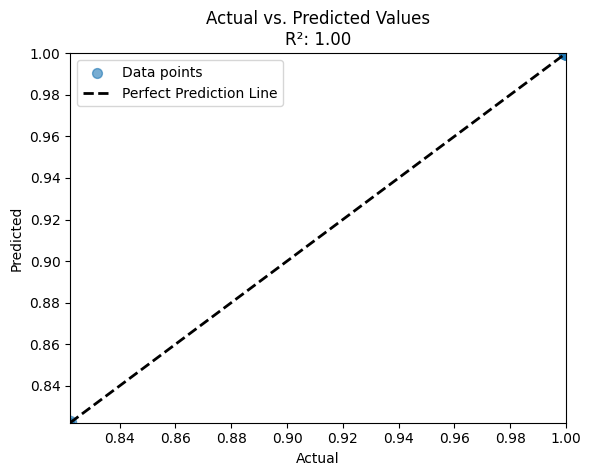

In [111]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

# Linear: Hybrid Text Metrics (Wasserstein Distance + Cosine) vs. Graph Metrics (Cosine) Fidelity Analysis.

In [112]:
# Combine the scaled Wasserstein distances and cosine similarities
Similarities_ = [wd + cos for wd, cos in zip(similarities_wd, similarities_cosine)]
# Print the combined list of similarities
print(Similarities_)

[np.float64(0.8223208527696352), np.float64(1.0), np.float64(0.8223208527696352), np.float64(1.0), np.float64(1.0), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(1.0), np.float64(1.0), np.float64(0.8223208527696352), np.float64(0.8223208527696352), np.float64(1.0), np.float64(0.8223208527696352), np.float64(1.0)]


In [113]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 1.77679147e-01,  1.46419577e-16,  8.02748600e-17,  8.09054130e-17,
       -9.20972825e-17, -1.59110830e-16, -5.31897953e-17,  9.72895392e-18,
       -1.58339366e-17,  1.28780615e-16])

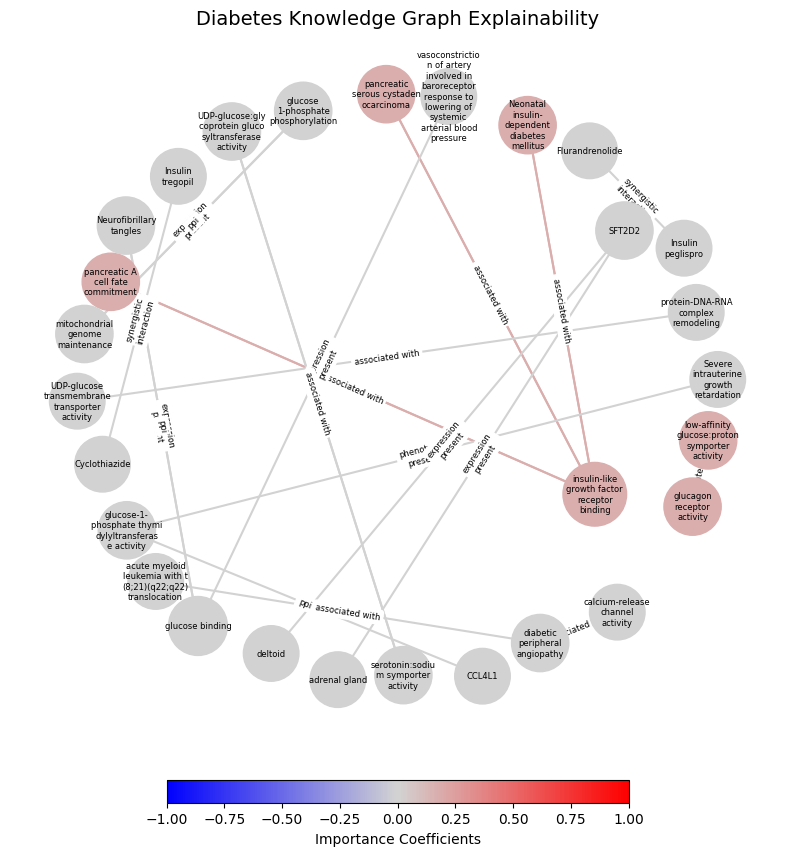

In [114]:
# # Call the function
plot_knowledge_graph_explainability(kg, portion_indices, coeff)


In [115]:
# Example inputs
y_true = np.array(Similarities_).ravel()
y_pred = simpler_model.predict(perturbations_vect2).ravel()

# Call the function
calculate_fidelity_metrics(y_true, y_pred, weights, coeff)

----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 2.827678082620065e-32
R-squared (R²): 1.0
Mean Absolute Error (MAE): 1.1093830084622477e-16
Mean Loss (Lm): 2.220446049250313e-16
Mean L1 Loss: 2.1649348980190552e-16
Mean L2 Loss: 6.34786509670033e-32
Weighted L1 Loss: 3.987746434593897e-17
Weighted L2 Loss: 1.016426527730724e-32
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------


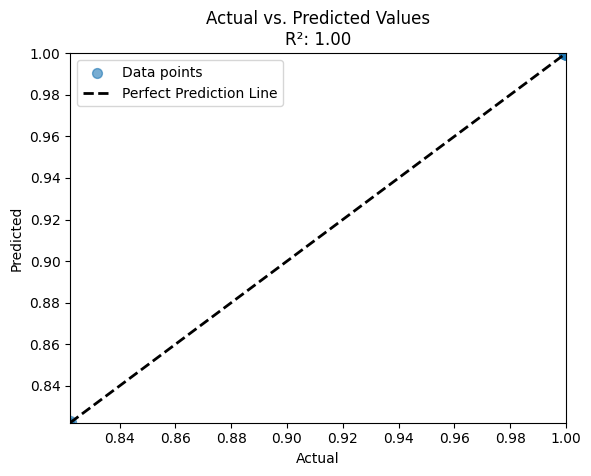

In [116]:
# Call the function
plot_actual_vs_predicted(y_true, y_pred, weights)

In [118]:
def get_coefficients(question, kg, part_names, portion_indices, temp=0):
    """
    Calculate coefficients for a given question using hybrid text metrics.

    Parameters:
    - question: Question string (e.g., "What is polycystic ovary syndrome?")
    - kg: Knowledge graph (list of triples)
    - part_names: List of part names in the KG
    - portion_indices: Dictionary mapping part names to index ranges
    - temp: Temperature (default 0)

    Returns:
    - coeff: Coefficients array
    """
    import sklearn.metrics
    import numpy as np
    from scipy.stats import wasserstein_distance
    from scipy.spatial.distance import cosine
    from sklearn.linear_model import LinearRegression
    import random

    # Define the original vector (all parts present)
    original = np.ones(len(part_names)).reshape(1, -1)

    # Create original graph
    graph = NetworkxEntityGraph()
    for node1, relation, node2 in kg:
        graph.add_triple(KnowledgeTriple(node1, relation, node2))

    # Get original answer and embedding
    original_answer_str, original_answer_embedding = get_answer_and_embedding(question, temp, graph)

    # Initialize lists
    similarities_wd = []
    similarities_cosine = []
    perturbations_vect2 = []
    epsilon = 1e-6

    # Loop for perturbations
    for i in range(20):
        perturbation_vector = original.copy().flatten()
        num_parts_to_remove = random.randint(1, len(part_names))
        parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)

        for part_idx in parts_to_remove_indices:
            perturbation_vector[part_idx] = 0

        perturbations_vect2.append(perturbation_vector)
        parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]

        # Create perturbed graph
        perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)
        graph_temp = NetworkxEntityGraph()
        for node1, relation, node2 in perturbed_kg:
            graph_temp.add_triple(KnowledgeTriple(node1, relation, node2))

        # Get perturbed answer and embedding
        temp_response, temp_response_embedding = get_answer_and_embedding(question, temp, graph_temp)

        # Convert embeddings to numpy arrays if needed
        orig_emb = np.array(original_answer_embedding) if isinstance(original_answer_embedding, list) else original_answer_embedding
        temp_emb = np.array(temp_response_embedding) if isinstance(temp_response_embedding, list) else temp_response_embedding

        # Calculate metrics
        similarity_wd = wasserstein_distance(orig_emb, temp_emb)
        similarities_wd.append(similarity_wd)

        similarity_cosine = 1 - cosine(orig_emb, temp_emb)
        similarities_cosine.append(similarity_cosine)

    # Convert to numpy array
    perturbations_vect2 = np.array(perturbations_vect2)

    # Calculate weights
    distances = sklearn.metrics.pairwise_distances(perturbations_vect2, original, metric='cosine').ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))

    # Scale Wasserstein distances
    inverse_similarities_wd = [1.0 / (dist + epsilon) for dist in similarities_wd]
    min_value = min(inverse_similarities_wd)
    max_value = max(inverse_similarities_wd)

    if max_value == min_value:
        scaled_similarities_wd = [1.0 for _ in inverse_similarities_wd]
    else:
        scaled_similarities_wd = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]

    # Combine similarities
    Similarities_ = [wd + cos for wd, cos in zip(scaled_similarities_wd, similarities_cosine)]

    # Train model and get coefficients
    model = LinearRegression()
    model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)
    coeff = model.coef_

    return coeff

In [119]:
# Get coefficients for your question
coeff = get_coefficients(
    question="What is insulin-like growth factor receptor binding associated with??",
    kg=kg,
    part_names=part_names,
    portion_indices=portion_indices,
    temp=0
)

print("Coefficients:", coeff)

Coefficients: [ 1.17845994e+00 -9.77870800e-17  3.32301022e-16 -2.51685574e-16
  4.72288033e-16  4.14015148e-16 -4.79785032e-16 -8.46903075e-17
  2.08711371e-16 -7.20565196e-19]


# Number of perturb
Evaluating Robustness Across Perturbations: This analysis explores the impact of varying numbers of perturbations  on the fidelity of both text and graph representations. By systematically introducing perturbations, we assess how sensitive the representations are to changes and identify key patterns in their robustness. This approach provides valuable insights into the stability of explainability metrics and highlights the thresholds where fidelity begins to degrade, offering a comprehensive understanding of the model's behavior under varying conditions."


Running for 10 iterations...


--- Summary of Perturbations ---
Perturbation 1: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 2: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 3: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 4: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 5: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 6:  Insulin-like growth factor receptor binding is associated with neonatal insulin-dependent diabetes mellitus, pancreatic A cell fate commitment, and pancreatic serous cystadenocarcinoma.
Perturbation 7: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 8:  Insulin-like growth factor receptor binding

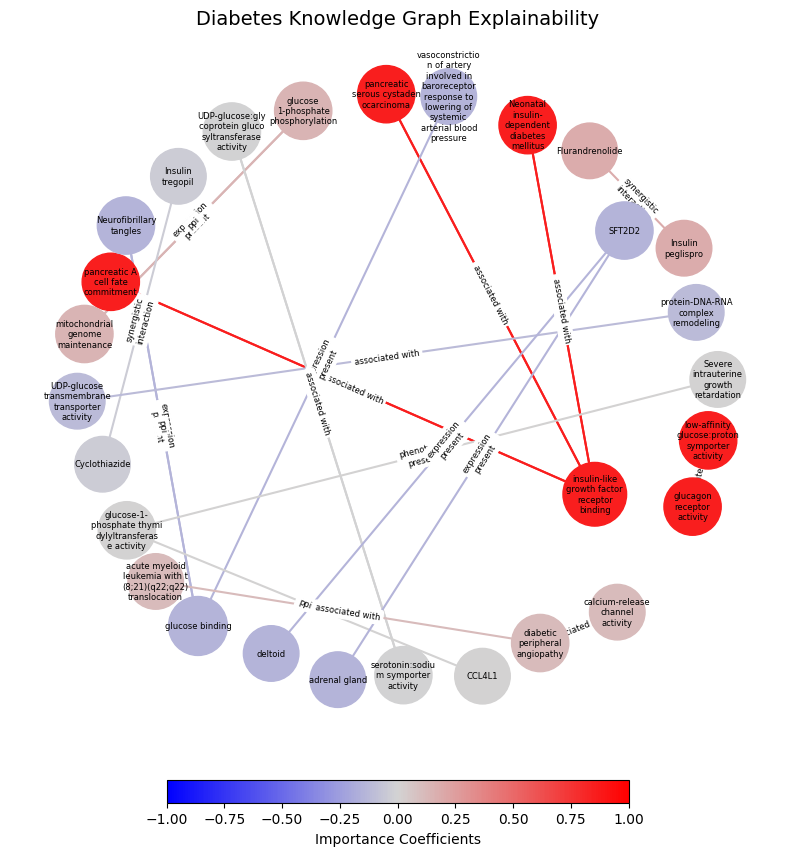

Calculating fidelity metrics...
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 1.5929476886112916e-31
R-squared (R²): 1.0
Mean Absolute Error (MAE): 2.9874215867241627e-16
Mean Loss (Lm): 3.885780586188048e-16
Mean L1 Loss: 4.829470157119431e-16
Mean L2 Loss: 3.774052319021227e-31
Weighted L1 Loss: 1.4987619420341516e-16
Weighted L2 Loss: 7.991672089240724e-32
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------

Running for 30 iterations...


--- Summary of Perturbations ---
Perturbation 1: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 2: 

Insulin-like growth factor receptor binding is associated with cell growth and proliferation.
Perturbation 3: 

Insulin-like growth factor receptor binding is associated with cell g

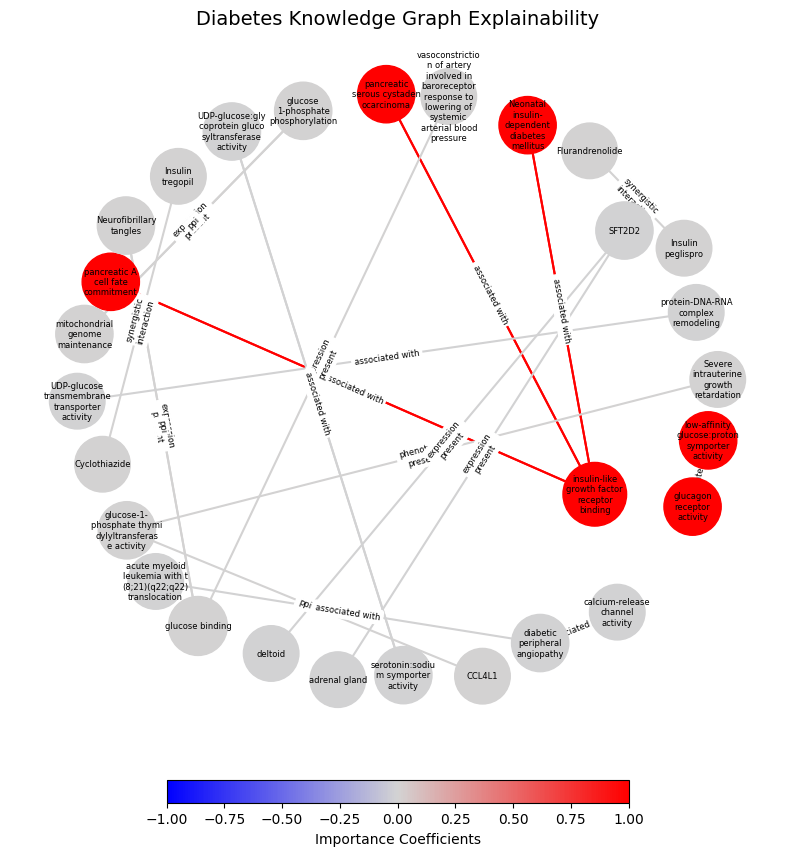

Calculating fidelity metrics...
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 4.924809892427425e-31
R-squared (R²): 1.0
Mean Absolute Error (MAE): 5.885526958495074e-16
Mean Loss (Lm): 1.1102230246251565e-16
Mean L1 Loss: 5.216275978823485e-16
Mean L2 Loss: 3.986096591662641e-31
Weighted L1 Loss: 3.146671695515276e-16
Weighted L2 Loss: 2.633028444789848e-31
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------

Running for 60 iterations...


--- Summary of Perturbations ---
Perturbation 1:  Insulin-like growth factor receptor binding is associated with neonatal insulin-dependent diabetes mellitus, pancreatic A cell fate commitment, and pancreatic serous cystadenocarcinoma.
Perturbation 2:  Insulin-like growth factor receptor binding is associated with neonatal insulin-dependent dia

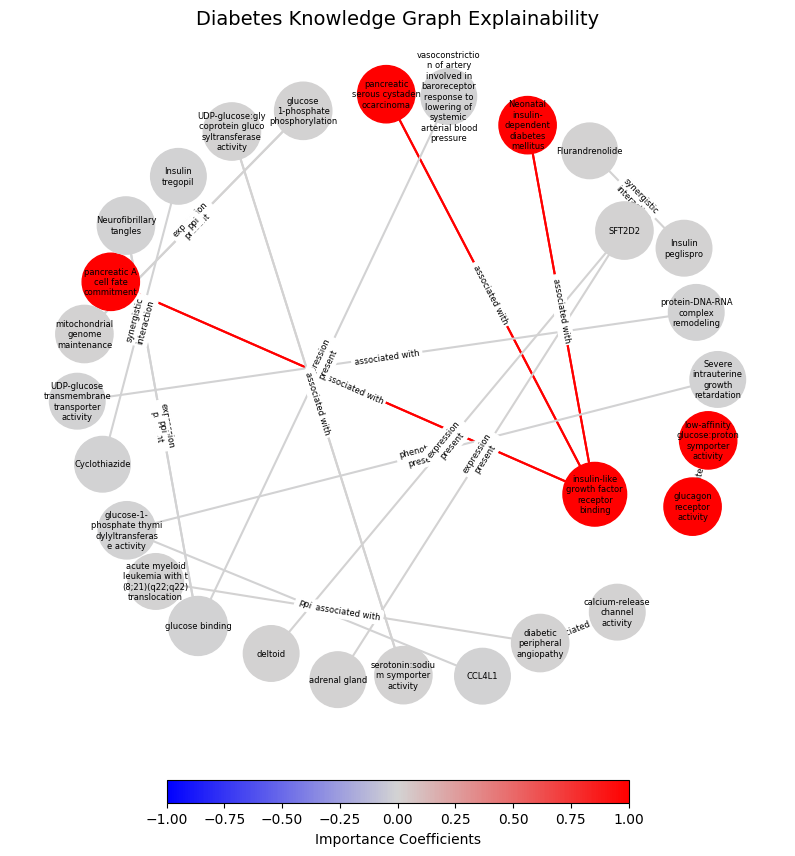

Calculating fidelity metrics...
----------------------------------------------------------------------------------------------------
Fidelity:
Mean Squared Error (MSE): 2.262486065099688e-30
R-squared (R²): 1.0
Mean Absolute Error (MAE): 1.2277939712225238e-15
Mean Loss (Lm): 2.220446049250313e-16
Mean L1 Loss: 1.18413576635004e-15
Mean L2 Loss: 2.128220555368432e-30
Weighted L1 Loss: 6.268369214195168e-16
Weighted L2 Loss: 1.1550877696438945e-30
Weighted R-squared (R²ω): 1.0
Weighted Adjusted R-squared (Rˆ²ω): 1.0
----------------------------------------------------------------------------------------------------

Running for 120 iterations...



In [ ]:
# Define the iteration counts
iteration_counts = [10, 30, 60, 120]
coefficients_list=[]
for iteration_count in iteration_counts:
    print(f"\nRunning for {iteration_count} iterations...\n")

    similarities_wd = []
    similarities_cosine = []
    perturbations_vect2 = []
    perturbation_texts = []  # Store the perturbation texts

    # Loop for perturbations
    for i in range(iteration_count):
        # Make a copy of the original vector for each iteration
        perturbation_vector = original.copy().flatten()

        # Randomly choose one or more parts to remove
        num_parts_to_remove = random.randint(1, len(part_names))
        parts_to_remove_indices = random.sample(range(len(part_names)), num_parts_to_remove)

        # Set the selected parts to 0 in the perturbation vector
        for part_idx in parts_to_remove_indices:
            perturbation_vector[part_idx] = 0

        # Append the perturbation vector to perturbations_vect2
        perturbations_vect2.append(perturbation_vector)

        # Perturb the KG by removing the selected parts
        parts_to_remove = [part_names[idx] for idx in parts_to_remove_indices]
        perturbed_kg = perturb_kg_by_removing_parts(kg, parts_to_remove, portion_indices)

        # Create a temporary graph for the perturbed KG
        graph_temp = NetworkxEntityGraph()
        for (node1, relation, node2) in perturbed_kg:
            graph_temp.add_triple(KnowledgeTriple(node1, relation, node2))

        # Generate response using GraphQAChain
        chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph_temp, verbose=False)
        temp_response = chain.run(question)

        # Store the perturbed response text
        perturbation_texts.append(temp_response)

        # Get embedding for the perturbed response
        temp_response_embedding = get_embedding(temp_response)

        # Calculate Wasserstein distance between the original and perturbed responses
        similarity_wd = wasserstein_distance(original_answer_embedding, temp_response_embedding)
        similarities_wd.append(similarity_wd)

        # Calculate cosine similarity between the original and perturbed responses
        similarity_cosine = 1 - cosine(original_answer_embedding, temp_response_embedding)
        similarities_cosine.append(similarity_cosine)

        # print(f"Iteration {i + 1}")
        # print(f"Parts removed: {parts_to_remove}")
        # print(f"original_answer response: {original_answer_str}")
        # print(f"Perturbed response: {temp_response}")
        # print(f"Wasserstein Distance with original answer: {similarity_wd}")
        # print(f"Cosine Similarity with original answer: {similarity_cosine}\n")

    # Convert perturbations_vect2 to a numpy array for pairwise distance calculation
    perturbations_vect2 = np.array(perturbations_vect2)

    # Calculate cosine distances between perturbation vectors and the original vector
    distances = sklearn.metrics.pairwise_distances(perturbations_vect2, original, metric='cosine').ravel()

    # Assuming you may use kernel width in further computations
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2) / kernel_width**2))

    # Print all similarities and weights
    # print(f"\nResults for {iteration_count} Iterations")
    # print(f"Wasserstein Distances: {similarities_wd}")
    # print(f"Cosine Similarities: {similarities_cosine}")
    # print(f"Weights: {weights}")

    # Optionally print all perturbation texts together for a consolidated view
    print("\n--- Summary of Perturbations ---")
    for i, text in enumerate(perturbation_texts):
        print(f"Perturbation {i + 1}: {text}")
    epsilon = 1e-6

    # Calculate the inverse of each Wasserstein distance, adding a small epsilon to avoid division by zero
    inverse_similarities_wd = [1.0 / (dist + epsilon) for dist in similarities_wd]

    # Find the minimum and maximum of the inverse Wasserstein distances
    min_value = min(inverse_similarities_wd)
    max_value = max(inverse_similarities_wd)

    Similarities_ = [(value - min_value) / (max_value - min_value) for value in inverse_similarities_wd]

    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations_vect2, y=Similarities_, sample_weight=weights)

    # Get coefficients and store them
    coeff = simpler_model.coef_
    coefficients_list.append(coeff)

    # 1. Visualize the knowledge graph with the current coefficients
    print("Plotting knowledge graph explainability...")
    plot_knowledge_graph_explainability(kg, portion_indices, coeff)

    # 2. Calculate fidelity metrics
    print("Calculating fidelity metrics...")

    y_true = np.array(Similarities_).ravel()
    y_pred = simpler_model.predict(perturbations_vect2).ravel()

    # Call the function
    calculate_fidelity_metrics(y_true, y_pred, weights, coeff)